In [392]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import time

from scipy.stats import norm, skewnorm, gamma
%load_ext autoreload
%autoreload 2

In [3]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [4]:
from koopman_probabilistic import KoopmanProb
from model_objs import GammaNLL, SkewNormalNLL

In [190]:
def pinball_loss(data, quant_preds, quantiles):
    assert(len(data) == len(quant_preds))
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [458]:
def nmb(data, pred):
    """Normalized mean bias"""
    assert(len(data) == len(pred))
    return np.mean(pred - data) / np.mean(data)

def nrmse(data, pred):
    """Normalized root mean square error"""
    assert(len(data) == len(pred))
    sorted_data = sorted(data)
    o05 = sorted_data[int(len(data) * 0.05)]
    o95 = sorted_data[int(len(data) * 0.95)]
    return np.sqrt(np.mean((data - pred)**2)) / (o95 - o05)

from scipy.stats import pearsonr
def correlation(data, pred):
    """Normalized mean bias"""
    assert(len(data) == len(pred))
    return pearsonr(data, pred)[0]    

In [508]:
import json
with open(".\\atmo_chem\\NASAcomparison.json") as f:
    NASAcomparison = json.loads(f.read())
NASAcomparison

{'Station0004436': {}}

In [509]:
station_name = 'Station0004436'
NASAcomparison[station_name] = dict()

station_path = ".\\atmo_chem\\seattle\\" + station_name
obsfile = os.path.join(station_path, 'obs_%s.csv'.replace('%s',station_name))
obs = pd.read_csv(obsfile, parse_dates=['ISO8601','localtime'], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
obs["t"] = [time.mktime(obs.ISO8601.iloc[i].timetuple()) for i in range(len(obs))]
t_min = obs.t.min()
obs.t -= t_min
obs_no2 = obs.loc[obs.obstype=='no2']
obs_o3 = obs.loc[obs.obstype=='o3']
obs_pm25 = obs.loc[obs.obstype=='pm25']
 
modfile = os.path.join(station_path, 'model_forecast_%s.csv'.replace('%s',station_name))
mod = pd.read_csv(modfile, parse_dates=['ISO8601','ISO8601_init'],date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601_init','ISO8601'])
mod["t"] = [time.mktime(mod.ISO8601.iloc[i].timetuple()) for i in range(len(mod))]
mod.t -= t_min


In [510]:
obs

,ISO8601,localtime,location,original_station_name,lat,lon,obstype,conc_mod,conc_obs,conc_unit,t
0,2018-01-01 02:00:00,2017-12-31 18:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,pm25,21.2877,5.6,ugm-3,0.0
1,2018-01-01 02:00:00,2017-12-31 18:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,31.6068,9.0,ppbv,0.0
2,2018-01-01 02:00:00,2017-12-31 18:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,o3,3.7835,18.0,ppbv,0.0
3,2018-01-01 12:00:00,2018-01-01 04:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,pm25,13.8420,13.1,ugm-3,36000.0
4,2018-01-01 12:00:00,2018-01-01 04:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,14.9303,13.0,ppbv,36000.0
...,...,...,...,...,...,...,...,...,...,...,...
66003,2021-03-14 19:00:00,2021-03-14 11:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,13.2423,15.0,ppbv,100972800.0
66005,2021-03-14 19:00:00,2021-03-14 11:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,pm25,12.7254,12.0,ugm-3,100972800.0
66007,2021-03-14 20:00:00,2021-03-14 12:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,o3,29.9769,16.0,ppbv,100976400.0
66006,2021-03-14 20:00:00,2021-03-14 12:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,11.4524,14.0,ppbv,100976400.0


<IPython.core.display.Javascript object>


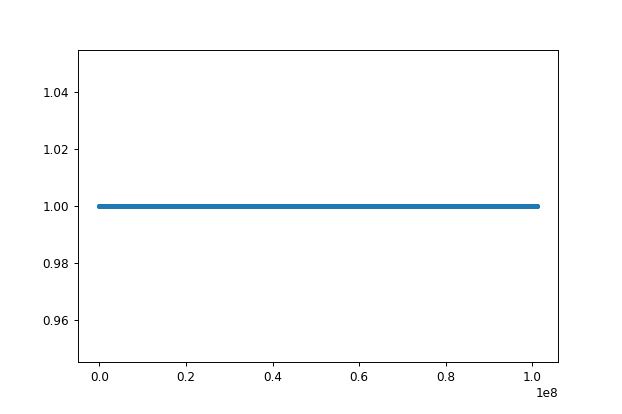

In [511]:
plt.figure()
plt.plot(obs.t, np.ones(len(obs.t)), ".")

In [517]:
diff = -(pd.to_datetime(mod.ISO8601_init) - pd.to_datetime(mod.ISO8601))
five_day_mod = mod[(diff > dt.timedelta(days=4)) & (diff < dt.timedelta(days=5))]
mods = dict()
for num_ahead in range(1, 6):
    mods[f"ahead{num_ahead}"] = mod[(diff > dt.timedelta(days=num_ahead - 0.5)) & (diff < dt.timedelta(days=num_ahead + 0.5))]

In [518]:
mods_no2 = [mods[x].NO2.values[:8707] for x in mods.keys()]
mods_no2 = np.array(mods_no2).T
mods_o3 = [mods[x].O3.values[:8707] for x in mods.keys()]
mods_o3 = np.array(mods_o3).T
mods_pm25 = [mods[x].PM25_RH35_GCC.values[:8707] for x in mods.keys()]
mods_pm25 = np.array(mods_pm25).T

In [519]:
mods_no2.shape,mods_o3.shape,mods_pm25.shape,

((8707, 5), (8707, 5), (8707, 5))

In [520]:
chemical = "NO2"
x = np.expand_dims(obs_no2.conc_obs.values, -1)
t = obs_no2.t.values
print("x", x.shape)
print("t", t.shape)

x (22331, 1)
t (22331,)


for flu data/integer data, use smooth parameter, discrete probability dist
NO2, O3, NO, HNO4, ISOP, N2O5, NIT, PRPE, SOAP
EMIS --all of them have very strong daily, weekly, and annual patterns
EMIS_ISOP (cleaner version of NO)

In [521]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [522]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (22331, 1)
t (22331,)


<IPython.core.display.Javascript object>


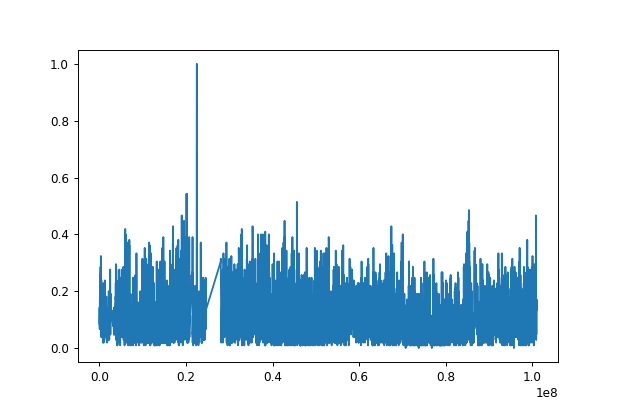

In [523]:
plt.figure()
plt.plot(t, x)

In [524]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [525]:
data_name = chemical + "Seattle_"

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (22331, 1)
xt (5314, 1)


In [526]:
mod_quant_preds = 1e9 / rnge * (mods_no2[1:, :] + mods_no2[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t]

In [527]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [528]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week
# k.find_fourier_omegas(xt, hard_code=[24, 168, 365.25 * 24 / 12, 24 * 365.25])  # Day, Week, Month, Year

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [529]:
k.fit(xt, tt, iterations=900, interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.7098248
Iteration  1
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.73715097
Iteration  2
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.759884
Iteration  3
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.7795271
Iteration  4
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.0155
Iteration  36
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.0215667
Iteration  37
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.0275964
Iteration  38
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.0341696
Iteration  39
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   60

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.2298018
Iteration  72
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.2346544
Iteration  73
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.2393408
Iteration  74
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.2441083
Iteration  75
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,  

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.3535608
Iteration  108
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.3554907
Iteration  109
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.358191
Iteration  110
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.3598249
Iteration  111
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4062375
Iteration  144
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4072846
Iteration  145
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4081852
Iteration  146
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.408996
Iteration  147
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4282589
Iteration  180
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4284899
Iteration  181
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4286838
Iteration  182
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4289726
Iteration  183
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4382561
Iteration  216
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4383165
Iteration  217
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.438417
Iteration  218
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4385657
Iteration  219
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4444187
Iteration  252
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4450734
Iteration  253
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4445273
Iteration  254
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4445678
Iteration  255
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4488454
Iteration  288
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4488358
Iteration  289
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4489518
Iteration  290
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4490066
Iteration  291
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4524828
Iteration  324
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4530325
Iteration  325
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.452984
Iteration  326
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4528608
Iteration  327
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4559602
Iteration  360
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4561664
Iteration  361
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4561889
Iteration  362
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4558617
Iteration  363
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4585527
Iteration  396
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4583843
Iteration  397
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4588362
Iteration  398
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4593014
Iteration  399
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4610217
Iteration  432
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.461688
Iteration  433
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4612553
Iteration  434
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4618052
Iteration  435
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4635149
Iteration  468
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4633851
Iteration  469
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4635329
Iteration  470
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.463823
Iteration  471
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4657652
Iteration  504
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4658103
Iteration  505
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4660058
Iteration  506
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4659089
Iteration  507
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4678556
Iteration  540
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4680461
Iteration  541
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4685968
Iteration  542
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4680979
Iteration  543
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4698992
Iteration  576
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4703965
Iteration  577
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4700397
Iteration  578
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4701619
Iteration  579
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4718771
Iteration  612
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4724715
Iteration  613
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4729329
Iteration  614
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4720412
Iteration  615
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4736227
Iteration  648
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4738545
Iteration  649
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4738746
Iteration  650
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4739754
Iteration  651
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4757035
Iteration  684
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4756172
Iteration  685
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4759319
Iteration  686
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4757103
Iteration  687
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4773389
Iteration  720
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4770987
Iteration  721
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4776493
Iteration  722
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.477261
Iteration  723
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4790537
Iteration  756
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4788471
Iteration  757
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4791656
Iteration  758
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4798305
Iteration  759
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.480212
Iteration  792
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4802378
Iteration  793
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4804779
Iteration  794
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.481015
Iteration  795
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4815753
Iteration  828
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4815357
Iteration  829
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4817138
Iteration  830
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.481513
Iteration  831
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4829807
Iteration  864
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4829105
Iteration  865
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.482966
Iteration  866
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4831269
Iteration  867
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -1.4839118
Final loss: -1.4839118


In [530]:
# params = k.predict(t[:predict_through])
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [531]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [532]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

<IPython.core.display.Javascript object>


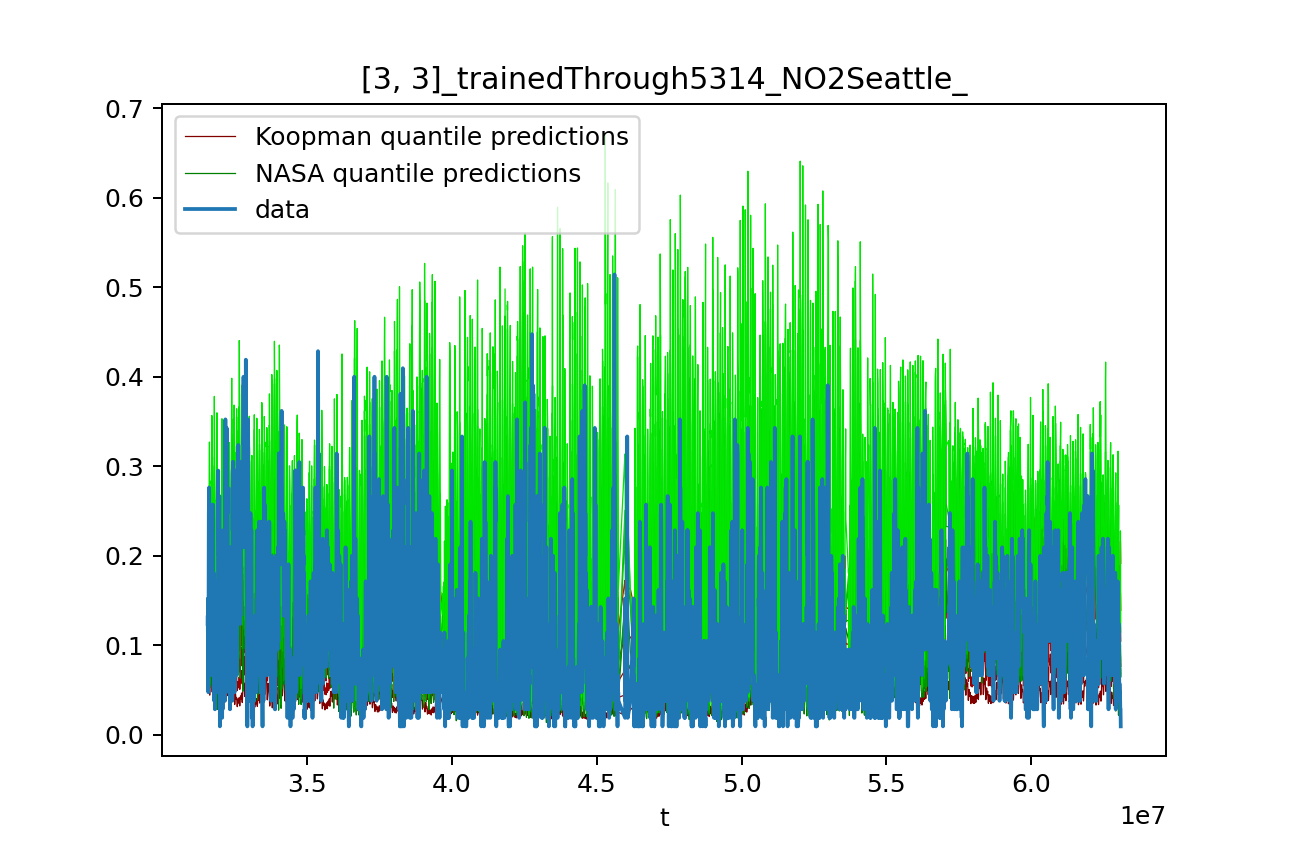

In [533]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [538]:
NASAcomparison[station_name][chemical] = {"koopman": dict(), "NASA": dict()}

In [539]:
NASAcomparison[station_name][chemical]["koopman"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], quant_preds, quantiles)
NASAcomparison[station_name][chemical]["koopman"]["nmb"] = nmb(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["correlation"] = correlation(x[koopman_test_idxs, 0], mean_hat[:, 0])

In [540]:
mod_mean = np.mean(mod_quant_preds[mod_test_idxs, :], axis=1)
NASAcomparison[station_name][chemical]["NASA"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], mod_quant_preds[mod_test_idxs, :], quantiles)
NASAcomparison[station_name][chemical]["NASA"]["nmb"] = nmb(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["correlation"] = correlation(x[koopman_test_idxs, 0], mod_mean)

In [541]:
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.021337167579866652,
    'nmb': -0.0296594234566004,
    'nrmse': 0.33222690897231794,
    'correlation': 0.29899686324309227},
   'NASA': {'pinball': 0.04026717408740582,
    'nmb': 0.6472492330132493,
    'nrmse': 0.5518908147298903,
    'correlation': 0.1724830769304259}}}}

<IPython.core.display.Javascript object>


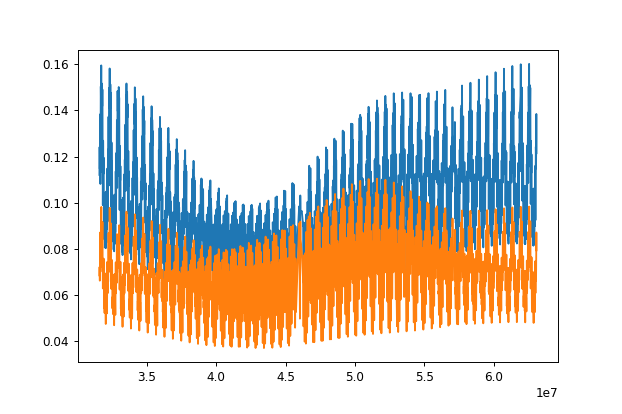

In [542]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

# CHEMICAL O3
## GET CHEMICAL

In [543]:
chemical = "O3"
x = np.expand_dims(obs_o3.conc_obs.values, -1)
t = obs_o3.t.values
print("x", x.shape)
print("t", t.shape)

x (21781, 1)
t (21781,)


In [544]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [545]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (21781, 1)
t (21781,)


<IPython.core.display.Javascript object>


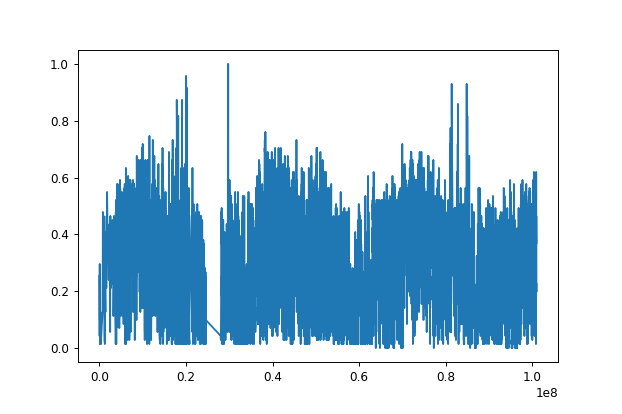

In [546]:
plt.figure()
plt.plot(t, x)

In [547]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [548]:
data_name = chemical + "Seattle_"

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (21781, 1)
xt (5041, 1)


In [549]:
mod_quant_preds = 1e9 / rnge * (mods_o3[1:, :] + mods_o3[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t]

In [550]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [551]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week
# k.find_fourier_omegas(xt, hard_code=[24, 168, 365.25 * 24 / 12, 24 * 365.25])  # Day, Week, Month, Year

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [552]:
k.fit(xt, tt, iterations=900, interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.036356565
Iteration  1
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.03180835
Iteration  2
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.026376171
Iteration  3
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.020768754
Iteration  4
tensor([   86400.,   604800., 31557600.,    86400.,   604800

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.12697963
Iteration  36
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.1311565
Iteration  37
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.13506374
Iteration  38
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.13998508
Iteration  39
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.2752147
Iteration  72
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.2790112
Iteration  73
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.28136027
Iteration  74
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.28561705
Iteration  75
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.37927952
Iteration  108
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.38128367
Iteration  109
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.38338557
Iteration  110
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.38663995
Iteration  111
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.43905854
Iteration  144
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.44045135
Iteration  145
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.44110554
Iteration  146
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.44172567
Iteration  147
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.4687298
Iteration  180
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.46926478
Iteration  181
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.4698562
Iteration  182
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.4704082
Iteration  183
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8640

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.48519248
Iteration  216
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.48500052
Iteration  217
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.4858941
Iteration  218
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.48600274
Iteration  219
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.49476856
Iteration  252
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.49523094
Iteration  253
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.49572337
Iteration  254
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.49612358
Iteration  255
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5020387
Iteration  288
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5023689
Iteration  289
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5027637
Iteration  290
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5039869
Iteration  291
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5085522
Iteration  324
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.50922275
Iteration  325
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.50843257
Iteration  326
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5076679
Iteration  327
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5147475
Iteration  360
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.51444167
Iteration  361
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5144394
Iteration  362
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5142964
Iteration  363
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8640

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.52045876
Iteration  396
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5186695
Iteration  397
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.51991796
Iteration  398
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5187731
Iteration  399
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.52356905
Iteration  432
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.52433944
Iteration  433
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.52436024
Iteration  434
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.52531123
Iteration  435
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.52857155
Iteration  468
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.52799016
Iteration  469
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.52828574
Iteration  470
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.52954614
Iteration  471
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.533147
Iteration  504
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.53323346
Iteration  505
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.53321934
Iteration  506
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5328918
Iteration  507
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8640

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5366687
Iteration  540
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5364827
Iteration  541
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.53690153
Iteration  542
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.53862643
Iteration  543
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5401151
Iteration  576
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5401255
Iteration  577
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5408187
Iteration  578
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5403212
Iteration  579
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.54276437
Iteration  612
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5432562
Iteration  613
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5447404
Iteration  614
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5445302
Iteration  615
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8640

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5464388
Iteration  648
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5456384
Iteration  649
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.54551184
Iteration  650
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.54654855
Iteration  651
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5496626
Iteration  684
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.54945666
Iteration  685
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5490029
Iteration  686
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.54842544
Iteration  687
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.55123335
Iteration  720
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5511538
Iteration  721
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.550938
Iteration  722
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.55133814
Iteration  723
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8640

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.55325043
Iteration  756
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5557444
Iteration  757
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.55321234
Iteration  758
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5544598
Iteration  759
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.555185
Iteration  792
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.55498177
Iteration  793
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5549318
Iteration  794
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.55605304
Iteration  795
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8640

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5573171
Iteration  828
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5575625
Iteration  829
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5573165
Iteration  830
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.55682856
Iteration  831
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8640

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5587926
Iteration  864
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.55838305
Iteration  865
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.558764
Iteration  866
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5592351
Iteration  867
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.55948937
Final loss: -0.55948937


In [553]:
# params = k.predict(t[:predict_through])
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [554]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [555]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

In [556]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>

In [557]:
NASAcomparison[station_name][chemical] = {"koopman": dict(), "NASA": dict()}

In [558]:
NASAcomparison[station_name][chemical]["koopman"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], quant_preds, quantiles)
NASAcomparison[station_name][chemical]["koopman"]["nmb"] = nmb(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["correlation"] = correlation(x[koopman_test_idxs, 0], mean_hat[:, 0])

In [559]:
mod_mean = np.mean(mod_quant_preds[mod_test_idxs, :], axis=1)
NASAcomparison[station_name][chemical]["NASA"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], mod_quant_preds[mod_test_idxs, :], quantiles)
NASAcomparison[station_name][chemical]["NASA"]["nmb"] = nmb(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["correlation"] = correlation(x[koopman_test_idxs, 0], mod_mean)

In [560]:
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.021337167579866652,
    'nmb': -0.0296594234566004,
    'nrmse': 0.33222690897231794,
    'correlation': 0.29899686324309227},
   'NASA': {'pinball': 0.04026717408740582,
    'nmb': 0.6472492330132493,
    'nrmse': 0.5518908147298903,
    'correlation': 0.1724830769304259}},
  'O3': {'koopman': {'pinball': 0.04711602243495071,
    'nmb': 0.06441101791084189,
    'nrmse': 0.3570856420432207,
    'correlation': 0.5505013327350501},
   'NASA': {'pinball': 0.0578864439022878,
    'nmb': 0.012223623417655838,
    'nrmse': 0.3052585492148005,
    'correlation': 0.524798462816694}}}}

In [561]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

<IPython.core.display.Javascript object>

# CHEMICAL PM25
## GET CHEMICAL

In [562]:
x, mods_pm25

(array([[0.25352113],
        [0.07042254],
        [0.04225352],
        ...,
        [0.23943662],
        [0.21126761],
        [0.22535211]]),
 array([[24.297377 , 32.22124  ,  6.047581 , 10.142984 , 29.188303 ],
        [24.409668 , 30.284449 ,  5.080129 ,  8.470082 , 28.749989 ],
        [24.81395  , 26.756079 ,  4.622326 ,  7.5199294, 25.37655  ],
        ...,
        [14.383428 ,  6.8592877, 12.308055 ,  9.89337  ,  7.293846 ],
        [14.714179 ,  7.131224 , 11.945132 ,  9.315447 ,  6.569568 ],
        [14.117114 ,  7.0349   , 11.160718 ,  8.598589 ,  5.024007 ]]))

In [563]:
chemical = "PM25"
x = np.expand_dims(obs_pm25.conc_obs.values, -1)
t = obs_pm25.t.values
print("x", x.shape)
print("t", t.shape)

x (21897, 1)
t (21897,)


In [564]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [565]:
x_original = x
rnge = np.std(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (21897, 1)
t (21897,)


In [566]:
plt.figure()
plt.plot(t, x)

<IPython.core.display.Javascript object>

In [567]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [568]:
data_name = chemical + "Seattle_"

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (21897, 1)
xt (6131, 1)


In [569]:
mod_quant_preds = 1 / rnge * (mods_pm25[1:, :] + mods_pm25[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t]

In [570]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [571]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week
# k.find_fourier_omegas(xt, hard_code=[24, 168, 365.25 * 24 / 12, 24 * 365.25])  # Day, Week, Month, Year

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [572]:
k.fit(xt, tt, iterations=900, interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.40927973
Iteration  1
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.4016719
Iteration  2
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.39689198
Iteration  3
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.3921762
Iteration  4
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.29885298
Iteration  37
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.2969009
Iteration  38
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.29533863
Iteration  39
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.29323307
Iteration  40
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.23727433
Iteration  73
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.23583114
Iteration  74
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.2360476
Iteration  75
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.23454133
Iteration  76
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.19905294
Iteration  109
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.19833067
Iteration  110
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.19774523
Iteration  111
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.19649477
Iteration  112
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.17314555
Iteration  145
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.17574885
Iteration  146
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.17441829
Iteration  147
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.17291872
Iteration  148
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.16157669
Iteration  181
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.16156583
Iteration  182
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1605087
Iteration  183
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.15948617
Iteration  184
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.15371485
Iteration  217
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.15450725
Iteration  218
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.15415257
Iteration  219
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.15431975
Iteration  220
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14780535
Iteration  253
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14869092
Iteration  254
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14848217
Iteration  255
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14657147
Iteration  256
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14599071
Iteration  289
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14557025
Iteration  290
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14528951
Iteration  291
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14344822
Iteration  292
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14317729
Iteration  325
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14277099
Iteration  326
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14202207
Iteration  327
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14301166
Iteration  328
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13963546
Iteration  361
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14098547
Iteration  362
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13931172
Iteration  363
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14096032
Iteration  364
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.14046672
Iteration  397
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13933174
Iteration  398
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13864774
Iteration  399
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13951123
Iteration  400
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13817595
Iteration  433
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13629845
Iteration  434
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13794073
Iteration  435
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13756184
Iteration  436
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13602996
Iteration  469
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13681804
Iteration  470
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13540614
Iteration  471
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13646942
Iteration  472
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1360023
Iteration  505
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13596143
Iteration  506
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13504481
Iteration  507
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1339903
Iteration  508
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13429207
Iteration  541
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1346537
Iteration  542
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13440682
Iteration  543
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13449186
Iteration  544
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13169199
Iteration  577
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13352561
Iteration  578
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1328464
Iteration  579
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1332067
Iteration  580
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13214523
Iteration  613
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13319707
Iteration  614
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13201848
Iteration  615
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13131231
Iteration  616
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13123998
Iteration  649
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13061522
Iteration  650
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1312565
Iteration  651
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1317357
Iteration  652
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13065194
Iteration  685
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12839092
Iteration  686
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13040167
Iteration  687
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13038094
Iteration  688
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12927757
Iteration  721
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.13048273
Iteration  722
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12961061
Iteration  723
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12971292
Iteration  724
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1285026
Iteration  757
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12717846
Iteration  758
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12756717
Iteration  759
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12715119
Iteration  760
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.123627804
Iteration  793
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12704368
Iteration  794
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1279423
Iteration  795
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12617137
Iteration  796
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12665349
Iteration  829
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12652288
Iteration  830
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1254892
Iteration  831
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12592457
Iteration  832
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12520874
Iteration  865
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12605776
Iteration  866
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.12546116
Iteration  867
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.1248754
Iteration  868
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

In [573]:
# params = k.predict(t[:predict_through])
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [574]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [575]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

In [576]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>

In [577]:
NASAcomparison[station_name][chemical] = {"koopman": dict(), "NASA": dict()}

In [578]:
NASAcomparison[station_name][chemical]["koopman"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], quant_preds, quantiles)
NASAcomparison[station_name][chemical]["koopman"]["nmb"] = nmb(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["correlation"] = correlation(x[koopman_test_idxs, 0], mean_hat[:, 0])

In [579]:
mod_mean = np.mean(mod_quant_preds[mod_test_idxs, :], axis=1)
NASAcomparison[station_name][chemical]["NASA"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], mod_quant_preds[mod_test_idxs, :], quantiles)
NASAcomparison[station_name][chemical]["NASA"]["nmb"] = nmb(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["correlation"] = correlation(x[koopman_test_idxs, 0], mod_mean)

In [580]:
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.021337167579866652,
    'nmb': -0.0296594234566004,
    'nrmse': 0.33222690897231794,
    'correlation': 0.29899686324309227},
   'NASA': {'pinball': 0.04026717408740582,
    'nmb': 0.6472492330132493,
    'nrmse': 0.5518908147298903,
    'correlation': 0.1724830769304259}},
  'O3': {'koopman': {'pinball': 0.04711602243495071,
    'nmb': 0.06441101791084189,
    'nrmse': 0.3570856420432207,
    'correlation': 0.5505013327350501},
   'NASA': {'pinball': 0.0578864439022878,
    'nmb': 0.012223623417655838,
    'nrmse': 0.3052585492148005,
    'correlation': 0.524798462816694}},
  'PM25': {'koopman': {'pinball': 0.09267178476991941,
    'nmb': 0.2075957710596253,
    'nrmse': 0.4515603441794963,
    'correlation': 0.024094976778792635},
   'NASA': {'pinball': 0.503143918247036,
    'nmb': 3.4307214882701977,
    'nrmse': 2.116966500897678,
    'correlation': 0.2795028212219078}}}}

<IPython.core.display.Javascript object>


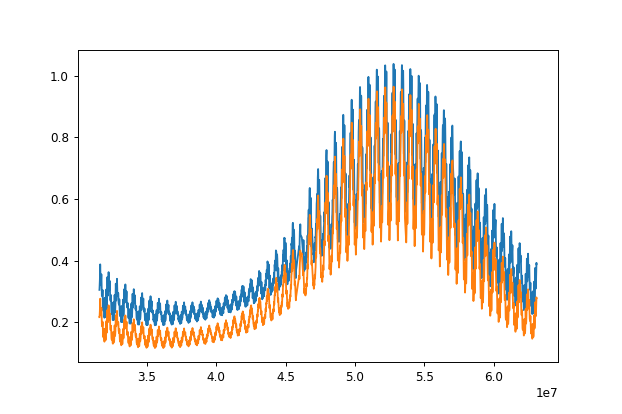

In [581]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

In [582]:
with open(".\\atmo_chem\\NASAcomparison.json", "w") as f:
    f.write(json.dumps(NASAcomparison))
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.021337167579866652,
    'nmb': -0.0296594234566004,
    'nrmse': 0.33222690897231794,
    'correlation': 0.29899686324309227},
   'NASA': {'pinball': 0.04026717408740582,
    'nmb': 0.6472492330132493,
    'nrmse': 0.5518908147298903,
    'correlation': 0.1724830769304259}},
  'O3': {'koopman': {'pinball': 0.04711602243495071,
    'nmb': 0.06441101791084189,
    'nrmse': 0.3570856420432207,
    'correlation': 0.5505013327350501},
   'NASA': {'pinball': 0.0578864439022878,
    'nmb': 0.012223623417655838,
    'nrmse': 0.3052585492148005,
    'correlation': 0.524798462816694}},
  'PM25': {'koopman': {'pinball': 0.09267178476991941,
    'nmb': 0.2075957710596253,
    'nrmse': 0.4515603441794963,
    'correlation': 0.024094976778792635},
   'NASA': {'pinball': 0.503143918247036,
    'nmb': 3.4307214882701977,
    'nrmse': 2.116966500897678,
    'correlation': 0.2795028212219078}}}}

In [246]:
a = 3
scale = 0.03
lins = np.linspace(1e-4, 1, 100)
gampdf = gamma.pdf(lins, a, scale=scale)

<IPython.core.display.Javascript object>


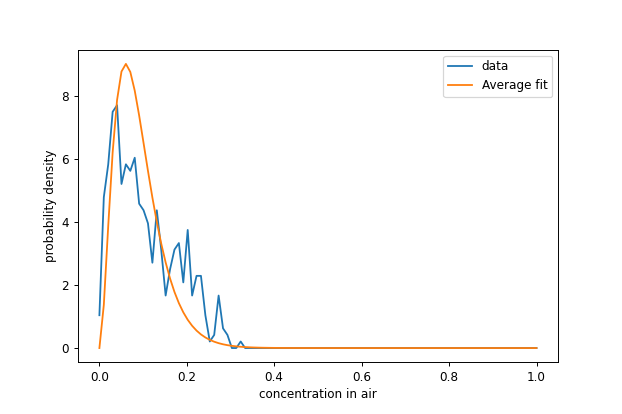

In [247]:
%matplotlib notebook
plt.figure()
hist, bin_edges = np.histogram(x[:24 * 20, 0], bins=100, range=(0, 1), density=True)
plt.plot(lins, hist, label="data")
plt.plot(lins, gampdf, label="Average fit")

plt.xlabel("concentration in air")
plt.ylabel("probability density")
plt.legend()
# plt.semilogx()
# plt.semilogy()
plt.show()